In [1]:
# imports
import os
os.environ['R_HOME'] = 'C:\\Users\\093637\\AppData\\Local\\Programs\\R\\R-4.3.1'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index as cindex
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [26]:
dataset_raw = pd.read_excel("W:/train_val_cohort.xlsx").set_index('ID').dropna()

patient_data = dataset_raw.drop(dataset_raw[dataset_raw['Synchronous'] == 1].index)
patient_data = patient_data.drop(['Slides', 'Synchronous'], axis=1)

patient_data.head()

,Event,Time,Treatment,Size,RTI,LVI
ID,,,,,,
TZ_01_IIID,0,87.00,0,4.0,0,0
TZ_06_F,0,46.52,0,1.9,0,0
TZ_07_D,0,82.04,1,3.0,1,0
TZ_10_D,0,92.65,0,1.0,0,0
TZ_11_I-C,0,84.83,1,5.5,0,0


In [27]:
def to_one_hot(dataframe, columns):
    '''
    Convert columns in dataframe to one-hot encoding.
    Args:
        dataframe (dataframe): pandas dataframe containing covariates
        columns (list of strings): list categorical column names to one hot encode
    Returns:
        one_hot_df (dataframe): dataframe with categorical columns encoded
                            as binary variables
    '''
  
    one_hot_df = pd.get_dummies(dataframe, columns=columns, drop_first=True)
    
    return one_hot_df

In [28]:
np.random.seed(12)
# df_dev, df_test = train_test_split(patient_data, test_size = 0.2, stratify=patient_data['Event'])
df_train, df_val = train_test_split(patient_data, test_size = 0.3, stratify=patient_data['Event'])

# Unskew and normalize data

continuous_columns = 'Size'

mean = np.log(df_train.loc[:, continuous_columns]+1).mean()
std = np.log(df_train.loc[:, continuous_columns]+1).std()
df_train.loc[:, continuous_columns] = (np.log(df_train.loc[:, continuous_columns]+1) - mean) / std
df_val.loc[:, continuous_columns] = (np.log(df_val.loc[:, continuous_columns]+1) - mean) / std



In [29]:
df_train

,Event,Time,Treatment,Size,RTI,LVI
ID,,,,,,
TCGA-4K-AAAL,1,4.83,1,-0.574625,0,1
TZ_97_2,0,293.62,1,0.128518,1,0
TZ_20_I-C,0,65.18,1,-1.014527,1,0
TZ_24_C,0,74.02,0,-1.014527,1,0
TZ_58_F,0,50.56,0,-1.778961,0,0
...,...,...,...,...,...,...
TCGA-ZM-AA06,0,49.22,1,0.847369,0,1
TZ_64_I-C,1,51.48,0,-1.581658,1,0
TCGA-XE-A9SE,0,23.26,1,1.174589,0,0


In [30]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(df_train, duration_col = 'Time', event_col = 'Event', fit_options={'step_size':0.1})

<lifelines.CoxPHFitter: fitted with 77 total observations, 64 right-censored observations>

In [31]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 77 total observations, 64 right-censored observations>
             duration col = 'Time'
                event col = 'Event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 77
number of events observed = 13
   partial log-likelihood = -42.32
         time fit was run = 2023-10-24 13:59:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Treatment  -1.17       0.31       0.84            -2.81             0.47                 0.06                 1.60
Size       -0.16       0.85       0.40            -0.94             0.62                 0.39                 1.85
RTI         0.59       1.80       0.60            -0.59             1.77                 0.56                 5.85
LVI         1.41       4.11       0.83            -0.21             3.04                 0.81                20.96

            cmp to     z    p   -log2(p)
covariate                               
Treatment     0.00 -1.40 0.16       2.62
Size          0.00 -0.41 0.68       0.55
RTI           0.00  0.98 0.33       1.61
LVI           0.00  1.70 0.09       3.49
---
Concordance = 0.72
Partial AIC = 92.64
log-likelihood ratio test = 6.42 on 4 df
-log2(p) of ll-ratio test = 2.56

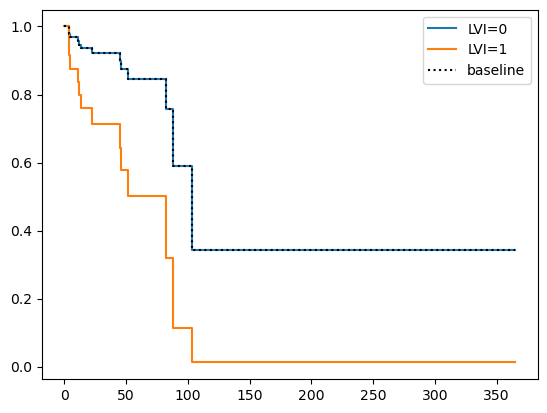

In [32]:
cph.plot_covariate_groups('LVI', values=[0, 1])

In [33]:
scores = cph.predict_partial_hazard(df_train)
cox_train_scores = cindex(df_train['Time'].values, scores.values, df_train['Event'].values)
# Validation
scores = cph.predict_partial_hazard(df_val)
cox_val_scores = cindex(df_val['Time'].values, scores.values, df_val['Event'].values)
# Test
# scores = cph.predict_partial_hazard(one_hot_test)
# cox_test_scores = cindex(one_hot_test['TimetoMetastasesOrEFU'].values, scores.values, one_hot_test['Metastases'].values)

print("Train:", cox_train_scores)
print("Val:", cox_val_scores)
# print("Test:", cox_test_scores)

Train: 0.2818965517241379
Val: 0.47019867549668876


In [14]:
%load_ext rpy2.ipython
%R require(ggplot2)

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

forest = rpackages.importr('randomForestSRC')

from rpy2 import robjects as ro
R = ro.r

from rpy2.robjects import pandas2ri
pandas2ri.activate()

c:\Users\093637\AppData\Local\anaconda3\envs\seminoma-relapse\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


Loading required package: ggplot2
RStudio Community is a great place to get help:
https://community.rstudio.com/c/tidyverse


In [15]:
print(base._libPaths())

['C:/Users/093637/AppData/Local/Programs/R/R-4.3.1/library']


In [82]:
df_dev, df_test = train_test_split(dataset_one_hot, test_size = 0.2, stratify=dataset_one_hot['Metastases'])
df_train, df_val = train_test_split(df_dev, test_size = 0.25, stratify=df_dev['Metastases'])

# Unskew and normalize data
mean = np.log(df_dev.loc[:, continuous_columns]+1).mean()
std = np.log(df_dev.loc[:, continuous_columns]+1).std()
df_train.loc[:, continuous_columns] = (np.log(df_train.loc[:, continuous_columns]+1) - mean) / std
df_val.loc[:, continuous_columns] = (np.log(df_val.loc[:, continuous_columns]+1) - mean) / std
df_test.loc[:, continuous_columns] = (np.log(df_test.loc[:, continuous_columns]+1) - mean) / std
df_dev.loc[:, continuous_columns] = (np.log(df_dev.loc[:, continuous_columns]+1) - mean) / std

In [50]:
df_dev_pos = df_dev[df_dev['Metastases'] == 1]

In [52]:
df_dev = pd.concat([df_dev, df_dev_pos])

In [84]:
model = forest.rfsrc(ro.Formula('Surv(TimetoMetastasesOrEFU, Metastases) ~.'), data=df_train, ntree=5, nodedepth=10)

In [85]:
result = R.predict(model, newdata=df_val)
scores = np.array(result.rx('predicted')[0])

print("Cox Model Validation Score:", cox_val_scores)
print("Survival Forest Validation Score:", cindex(df_val['TimetoMetastasesOrEFU'].values, scores, df_val['Metastases'].values))

Cox Model Validation Score: 0.9090909090909091
Survival Forest Validation Score: 0.5


In [79]:
df_dev = df_dev.astype(float)

In [88]:
result = R.predict(model, newdata=df_test)
scores = np.array(result.rx('predicted')[0])

print("Cox Model Test Score:", cox_test_scores)
print("Survival Forest Validation Score:", cindex(df_test['TimetoMetastasesOrEFU'].values, scores, df_test['Metastases'].values))

Cox Model Test Score: 0.75
Survival Forest Validation Score: 0.5


In [92]:
forest.vimp(model).rx('importance')[0]

array([0., 0., 0., 0.])

In [52]:
from sksurv.tree import SurvivalTree

In [53]:
tree = SurvivalTree(max_depth=4)

In [54]:

# Iterate over the rows and create tuples
y_train = np.array([(a, b) for a, b in zip(df_train['Event'], df_train['Time'])], dtype='bool,f')
y_val = np.array([(a, b) for a, b in zip(df_val['Event'], df_val['Time'])], dtype='bool,f')

In [55]:
tree.fit(df_train.drop(columns=['Time', 'Event']), y_train)

SurvivalTree(max_depth=4)

In [56]:
tree.score(df_train.drop(columns=['Time', 'Event']), y_train)

0.8112068965517242

In [57]:
tree.score(df_val.drop(columns=['Time', 'Event']), y_val)

0.4304635761589404

In [58]:
test_datset = pd.read_spss('W:\Cohort_EMC\WSIproject_StageI_Anonymized.sav')

dataset_cox_test = test_datset[['TimetoMetastasesOrEFU', 'Metastases', 'LVI', 'RTI', 'AdjuvantTreatment', 'TumorSize']].replace({'Yes': 1, 'No': 0}).dropna(axis=0)

In [144]:
y_test = np.array([(a, b) for a, b in zip(dataset_cox_test['Metastases'], dataset_cox_test['TimetoMetastasesOrEFU'])], dtype='bool,f')

In [145]:
tree.score(dataset_cox_test.drop(columns=['TimetoMetastasesOrEFU', 'Metastases']), y_test)

0.5643491124260355

In [59]:
X_train = df_train.drop(columns=['Time', 'Event'])
X_val = df_val.drop(columns=['Time', 'Event'])

In [68]:
from sksurv.tree import SurvivalTree
from sklearn.model_selection import GridSearchCV, train_test_split
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest

param_grid = {
    'max_depth': [None, 2, 5, 10, 20],  # Specify the values you want to try for max_depth
    'min_samples_split': [2, 5, 10]  # Specify the values you want to try for min_samples_split
}

# Create the SurvivalTree model
tree = RandomSurvivalForest()

# Initialize GridSearchCV
grid_search = GridSearchCV(tree, param_grid, cv=3, n_jobs=-1)

# Fit the model using the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': None, 'min_samples_split': 2}
Best score found:  0.42551546391752576


In [69]:
tree = RandomSurvivalForest(max_depth=None, min_samples_split=5)
tree.fit(X_train, y_train)

RandomSurvivalForest(min_samples_split=5)

In [70]:
tree.score(X_train, y_train)

0.8793103448275862

In [72]:
tree.score(X_val, y_val)

0.6258278145695364